# Machine Learning Avanzado MDS19 UDD


## Desafío 3: Redes Neuronales.






#### Profesores   : José García, Francisco Altimiras.
#### Alumnos      : Roy Barrera, José Pérez.


### Resumen

Para responder al desafío 3 de este curso, que dice relación con las Redes Neuronales, hemos decidido implementar modelos predictivos basados en Redes Neuronales, para complementar un trabajo previo realizado en el curso de "Taller de proyecto aplicado" de este mismo Magister.
Basicamente el trabajo realizado previamente buscaba predecir el estado de funcionamiento de Bombas de agua en Tanzania. A los modelos predictivos implementados, se agregan ahora modelos predictivos basados en Redes Neuronales, usando para ello en un caso Keras y en el otro caso sklearn.


Dicho lo anterior, se aborda este desafío 3.

El objetivo perseguido es mediante modelos predictivos, conocer el estado funcional de Bombas de agua en Tanzania. 

Son 3 los estados que puede tener una Bomba de agua:

* Functional: La Bomba de agua se encuentra operativa.

* Functional needs repair: La Bomba de agua esta opertaiva, pero necesita repaciones.

* Non functional: La Bomba de agua no esta operativa.

Para ello se cuenta con un dataset de 59400 muestras y 41 variables(incluyendo la variable objetivo)


El desarrollo de este trabajo consta de 3 puntos:

1) __Exploración y manipulación del DataSet__

2) __Modelamiento__

3) __Conclusión__


# <a> ÍNDICE</a>

- <a href='#1'>1. Exploración y manipulación del DataSet</a>
- <a href='#2'>2. Modelamiento</a>
    - <a href='#2.1'>2.1. Regresión Logística</a>
    - <a href='#2.2'>2.2. Regresión Logística usando SMOTE</a>
    - <a href='#2.3'>2.3. LightGBMClassifier</a>
    - <a href='#2.4'>2.4. XGBClassifier</a>
    - <a href='#2.5'>2.5. BalancedBaggingClassifier</a>
    - <a href='#2.6'>2.6. Red Neuronal usando Keras</a>
    - <a href='#2.7'>2.7. Red Neuronal MLPClassifier de sklearn</a>
- <a href='#3'>3. Rendimiento de los modelos</a>
    - <a href='#3.1'>3.1. Comparación de métricas</a>
    - <a href='#3.2'>3.2. Matrices de confusión de los modelos</a>
- <a href='#4'>4. Conclusión</a>    

# <a id='1'>1. Exploración y manipulación del DataSet</a>
En principio este trabajo se desarrolló sobre Jupyter-Notebook, y al incorporar los modelos predictivos usando Redes Neuronales, debido al necesidad de más recurso de memoria y procesamiento, es que retomamos su desarrollo en la plataforma Google-Colab.

In [0]:
# Dado que se esta trabajando con Google Colab, lo primero que hacemos  es
# montar Google-Drive, en donde está el DataSet a ser procesado.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Se importa la libreria pandas para la lectura del dataset.
import pandas as pd

In [0]:
# Se leen los dataset a ser procesados.

# Se importa la libreria os
import os
# path es la ruta donde estan los dataset
path = '/content/drive/My Drive/Colab Notebooks/03_Advanced_Machine_Learning/'

# El Dataset 03_dataset_training.csv con el universo de variables recolectadas
# (no considera la variable objetivo)
df_01=pd.read_csv(os.path.join(path, '03_dataset_training.csv'), sep=',')

# El Dataset 04_salidas_del_training.csv contiene la variable objetivo
df_02=pd.read_csv(os.path.join(path, '04_salidas_del_training.csv'), sep=',')

# Se define la función ve_df(), para mirar un dataframe.
def ve_df(df):
    print ("# Muestras       : {:>7}".format(df.shape[0]))
    print ("# Variables      : {:>7}".format(df.shape[1]), "\n")
    print ("Variables        : \n" ,df.columns.tolist())
    print ("\n# Muestras  con  nulos    : {:>6}".format(df.isnull().sum().values.sum()))
    print ("\nValores únicos x variable :  ")
    print (df.nunique())

# Se miran ambos dataset leídos.
ve_df(df_01)
ve_df(df_02)


# Muestras       :   59400
# Variables      :      40 

Variables        : 
 ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

# Muestras  con  nulos    :  46094

Valores únicos x variable :  
id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name

In [0]:
# Se identifican todas las variables con muestras que contengan valores nulos.
def var_null(df):
    lvar_null = [i for i in df.columns if df[i].isnull().sum() > 0]
    return lvar_null

# Se reemplazan los valores nulos
def reemplaza_null(df, lvar, valor):
    for var in lvar:
        df[var].fillna(valor, inplace = True)

print(var_null(df_01))
reemplaza_null(df_01, var_null(df_01), 'No_informado')


['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']


In [0]:
# Se define la función obj_2_cat(), que convierte las variables tipo objeto 
# de un dataframe, en categóricas.
def obj_2_cat(df,cat_codes=True):
    # Se identifican las variables tipo object
    l_v_obj = []
    l_v_obj = list(df.select_dtypes(['O']).columns)

    if len(l_v_obj) > 0:
        # Conversión de variables tipo object a tipo category
        df[l_v_obj] = df[l_v_obj].astype("category")

        # Se reemplazan los textos de las variables categóricas, por su valor de categoría.
        if cat_codes == True:
            for var in l_v_obj:
                df[var]  = df[var].cat.codes

obj_2_cat(df_01)
obj_2_cat(df_02,cat_codes=False)
print(df_01.describe())
print(df_02.info())

                 id     amount_tsh  ...  waterpoint_type  waterpoint_type_group
count  59400.000000   59400.000000  ...     59400.000000           59400.000000
mean   37115.131768     317.650385  ...         2.574091               2.056212
std    21453.128371    2997.574558  ...         1.781438               1.378937
min        0.000000       0.000000  ...         0.000000               0.000000
25%    18519.750000       0.000000  ...         1.000000               1.000000
50%    37061.500000       0.000000  ...         2.000000               1.000000
75%    55656.500000      20.000000  ...         4.000000               3.000000
max    74247.000000  350000.000000  ...         6.000000               5.000000

[8 rows x 40 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   id            59400 non-null  int64   
 1   status_group

In [0]:
# Se eligen 16 variables predictoras.
lvar_pred = ['amount_tsh','funder','region_code','district_code',
             'public_meeting','scheme_management','construction_year',
             'extraction_type','extraction_type_group','extraction_type_class',
             'management_group','water_quality','quality_group','quantity',
             'source_class','waterpoint_type']

# Se identifica la variable objetivo.
var_objet = ['status_group']

# El dataset df_03 contiene las 16 variables predictoras elegidas.
df_03 = df_01[lvar_pred]
# El dataset df_04 contiene la variable objetivo.
df_04 = df_02[var_objet]

# Son mirados ambos dataset
ve_df(df_03)
print('\n')
ve_df(df_04)


# Muestras       :   59400
# Variables      :      16 

Variables        : 
 ['amount_tsh', 'funder', 'region_code', 'district_code', 'public_meeting', 'scheme_management', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management_group', 'water_quality', 'quality_group', 'quantity', 'source_class', 'waterpoint_type']

# Muestras  con  nulos    :      0

Valores únicos x variable :  
amount_tsh                 98
funder                   1898
region_code                27
district_code              20
public_meeting              3
scheme_management          13
construction_year          55
extraction_type            18
extraction_type_group      13
extraction_type_class       7
management_group            5
water_quality               8
quality_group               6
quantity                    5
source_class                3
waterpoint_type             7
dtype: int64


# Muestras       :   59400
# Variables      :       1 

Variables        :

In [0]:
# Se miran los dataset
print(df_03.describe())
print(df_04.describe())

          amount_tsh        funder  ...  source_class  waterpoint_type
count   59400.000000  59400.000000  ...  59400.000000     59400.000000
mean      317.650385    853.604983  ...      0.233737         2.574091
std      2997.574558    561.879176  ...      0.434129         1.781438
min         0.000000      0.000000  ...      0.000000         0.000000
25%         0.000000    446.000000  ...      0.000000         1.000000
50%         0.000000    657.500000  ...      0.000000         2.000000
75%        20.000000   1319.000000  ...      0.000000         4.000000
max    350000.000000   1897.000000  ...      2.000000         6.000000

[8 rows x 16 columns]
       status_group
count         59400
unique            3
top      functional
freq          32259


In [0]:
# Matriz de correlación del dataset df_03 

# Se importan librerías a ser usadas.
import numpy as np 

import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline

import itertools

import seaborn as sns
import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

correlation = df_03.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Coficiente Pearson de Correlacion",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Matriz de correlación de variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
#py.iplot(fig)
fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <a id='2'>2. Modelamiento</a>

## <a id='2.1'>2.1. Regresión Logística</a>

In [0]:
# Modelamiento predicctivo del estado de las Bombas de agua, usando Regresión Logística.

# Se importan las librerias requeridas.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

# Se realiza la división de las muestras en entrenamiento y prueba.
train_X,test_X,train_Y,test_Y = train_test_split(df_03,df_04,test_size = .25 ,random_state = 123)

# Se instancia el modelo.
logit  = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=150, multi_class='auto', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
# Modelo
logit.fit(train_X,train_Y)
predictions   = logit.predict(test_X)
probabilities = logit.predict_proba(test_X)
    
print (logit)
print ("\n Classification report : \n",classification_report(test_Y,predictions))
print ("Accuracy   Score : ",accuracy_score(test_Y,predictions))


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
                          precision    recall  f1-score   support

             functional       0.64      0.70      0.67      7963
functional needs repair       0.18      0.13      0.15      1076
         non functional       0.59      0.54      0.56      5811

               accuracy                           0.60     14850
              macro avg       0.47      0.46      0.46     14850
           weighted avg       0.59      0.60      0.59     14850

Accuracy   Score :  0.5974410774410774


## <a id='2.2'>2.2. Regresión Logística usando SMOTE</a>

In [0]:
# Es importada libreria requerida.
from imblearn.over_sampling import SMOTE

# Separación de variables predictoras de variable objetivo.
smote_X = df_03.copy()
smote_Y = df_04.copy()


# Split de datos de entrenamiento y de prueba
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 333)

# Oversampling de la clase minoritaría usando SMOTE
os = SMOTE(random_state = 333)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=lvar_pred)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=var_objet)



# Instanciación de la Regresión Logística
logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=333, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Modelo
logit_smote.fit(os_smote_X,os_smote_Y)
predictions   = logit_smote.predict(smote_test_X)
probabilities = logit_smote.predict_proba(smote_test_X)
    
print (logit)
print ("\n Classification report : \n",classification_report(smote_test_Y,predictions))
print ("Accuracy   Score : ",accuracy_score(smote_test_Y,predictions))


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

 Classification report : 
                          precision    recall  f1-score   support

             functional       0.68      0.39      0.49      8075
functional needs repair       0.13      0.55      0.21      1073
         non functional       0.56      0.56      0.56      5702

               accuracy                           0.47     14850
              macro avg       0.46      0.50      0.42     14850
           weighted avg       0.59      0.47      0.50     14850

Accuracy   Score :  0.4663973063973064


## <a id='2.3'>2.3. XGBClassifier</a>

In [0]:
# XGBClassifier
# Se importa la libreria a ser usada.
from xgboost import XGBClassifier


xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=333,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

# Modelo
xgc.fit(os_smote_X,os_smote_Y)
predictions   = xgc.predict(test_X)
probabilities = xgc.predict_proba(test_X)
    
print (xgc)
print ("\n Classification report : \n",classification_report(test_Y,predictions))
print ("Accuracy   Score : ",accuracy_score(test_Y,predictions))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=333,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

 Classification report : 
                          precision    recall  f1-score   support

             functional       0.86      0.86      0.86      7963
functional needs repair       0.43      0.66      0.52      1076
         non functional       0.88      0.81      0.84      5811

               accuracy                           0.82     14850
              macro avg       0.73      0.77      0.74     14850
           weighted avg       0.84      0.82      0.83     14850

Accuracy   Score :  0.8220875420875421


## <a id='2.4'>2.4. LGBMClassifier</a>

In [0]:
# LightGBMClassifie

# Se importa la libreria requerida
from lightgbm import LGBMClassifier

# Se instancia el modelo.
lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

# Modelo
lgbm_c.fit(os_smote_X,os_smote_Y)
predictions   = lgbm_c.predict(test_X)
probabilities = lgbm_c.predict_proba(test_X)
    
print (lgbm_c)
print ("\n Classification report : \n",classification_report(test_Y,predictions))
print ("Accuracy   Score : ",accuracy_score(test_Y,predictions))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
                          precision    recall  f1-score   support

             functional       0.84      0.85      0.85      7963
functional needs repair       0.42      0.63      0.50      1076
         non functional       0.88      0.78      0.82      5811

               accuracy                           0.81     14850
              macro avg       0.71      0.75      0.73     14850
           weighted avg       0.82      0.81      0.81     14850

Accuracy   Score :  0.8076094276094276


## <a id='2.5'>2.5. BalancedBaggingClassifier</a>


In [0]:
# BalancedBaggingClassifier

# Se importan las librerias requeridas
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from imblearn.ensemble import BalancedBaggingClassifier

# Se instancia el modelo
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

# Modelo
bbc.fit(os_smote_X,os_smote_Y)
predictions   = bbc.predict(test_X)
probabilities = bbc.predict_proba(test_X)
    
print (bbc)
print ("\n Classification report : \n",classification_report(test_Y,predictions))
print ("Accuracy   Score : ",accuracy_score(test_Y,predictions))



BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                p

## <a id='2.6'>2.6. Red Neuronal usando Keras.</a>

A continuación se usa Keras para modelar una Red Neuronal, predictiva de los estados de las Bombas de agua.


In [0]:
# Se importan las librerias requeridas.
import tensorflow
import keras.utils
from   keras.models import Sequential
from   keras.layers import Dense, Dropout, Activation
# Se incorporan diferentes optimizadores que serán probados en la Red Neuronal,
# en la búsqueda de mejorar su rendimiento.
from   keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam, SGD, RMSprop



Using TensorFlow backend.


In [0]:
# Es necesario normalizar algunas de las variables a ser usadas. De tal forma
# que los modelos predictivos a ser implementados operen correctamente.

# Se import la libreria requerida.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Se define la función normaliza_df()
def normaliza_df(scaler, df):
  scaled_df = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_df, columns=df.columns.values)
  return scaled_df

# Se eligen las variables a ser normalizadas.
lvar_norm = ['amount_tsh','funder','construction_year']
lvar_otra = [var for var in df_03.columns if var not in lvar_norm]

df_03_norm            = normaliza_df(StandardScaler(),df_03[lvar_norm])
df_03_norm[lvar_otra] = df_03[lvar_otra]
# El df_03_norm tiene las muestras de las variables predictoras a ser usadas. 
df_03_norm.describe()


,amount_tsh,funder,construction_year,region_code,district_code,public_meeting,scheme_management,extraction_type,extraction_type_group,extraction_type_class,management_group,water_quality,quality_group,quantity,source_class,waterpoint_type
count,5.940000e+04,5.940000e+04,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,5.364466e-16,1.817140e-16,3.053039e-16,15.297003,5.629747,0.971027,7.739276,6.331279,3.936549,1.264663,3.638418,5.754293,2.263047,1.325758,0.233737,2.574091
std,1.000008e+00,1.000008e+00,1.000008e+00,17.587406,9.633649,0.374689,2.623470,4.213948,3.527073,1.626676,1.058579,0.900820,0.784268,0.803750,0.434129,1.781438
min,-1.059700e-01,-1.519209e+00,-1.366788e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.059700e-01,-7.254378e-01,-1.366788e+00,5.000000,2.000000,1.000000,8.000000,3.000000,1.000000,0.000000,4.000000,6.000000,2.000000,1.000000,0.000000,1.000000
50%,-1.059700e-01,-3.490192e-01,7.201960e-01,12.000000,3.000000,1.000000,8.000000,4.000000,2.000000,1.000000,4.000000,6.000000,2.000000,1.000000,0.000000,2.000000
75%,-9.929791e-02,8.282901e-01,7.391112e-01,17.000000,5.000000,1.000000,8.000000,9.000000,6.000000,2.000000,4.000000,6.000000,2.000000,2.000000,0.000000,4.000000
max,1.166561e+02,1.856990e+00,7.485689e-01,99.000000,80.000000,2.000000,12.000000,17.000000,12.000000,6.000000,4.000000,7.000000,5.000000,4.000000,2.000000,6.000000


In [0]:
# Se realiza la partición de las muestras para aplicar el entrenamiento de la 
# Red Neuronal.
from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_03_norm.copy()
y = df_04.apply(LabelEncoder().fit_transform).values.ravel()
y_cat = keras.utils.to_categorical(y, num_classes=3)

X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y_cat, test_size=0.25, stratify=y)

In [0]:
# Se define el modelo para la Red Neuronal. Esta Red Neuronal tiene una capa de 
# entrada con 64 neuronas, una capa oculta con 32 neuronas y una capa de salida
# con 3 neuronas.
model = Sequential()
# La primera capa tiene 64 'neuronas', función de activación relu y 16 variables
# de entrada.
model.add(Dense(64, activation='relu', input_dim=16))
# La segunda capa tiene 32 'neuronas' y función de activación relu.
model.add(Dense(32, activation='relu'))
# La capa de salida, considera las 3 clases y función de activación softmax.
model.add(Dense(3, activation='softmax'))

# Se usa el optimizador RMSprop, con valores de hiperparámetros tomados desde
# la documentación de Keras.
rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
# Se instancia el modelo, usando optimizador rmsprop, función de pérdida 
# categorical_crossentropy y métrica accuracy.
model.compile(optimizer=rmsprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Se mira el modelo y sus parámetros
model.summary()
# Se entrena la Red Neuronal, con epochs = 100 y batch_size = 32
model.fit(X_train_, y_train_, epochs=100, batch_size=32)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 3,267
Trainable params: 3,267
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
44550/44550 [==============================] - 2s 36us/step - loss: 0.8195 - accuracy: 0.6310
Epoch 2/100
44550/44550 [==============================] - 2s 34us/step - loss: 0.7426 - accuracy: 0.6835
Epoch 3/100
44550/44550 [==============================] - 2s 34us/step - loss: 0.7022 - accuracy: 0.7069
Epoch 4/100
44550/44550 [==============================] - 2s 34

En este primer intento se logra un accuracy del 0.74, un valor que se puede considerar aceptable.
Evaluemos ahora la red entrenada con las muestras de test.

In [0]:
import pandas as pd
# Se evalua la Red Neuronal ya entrenada, con las muestras de prueba.
score = model.evaluate(X_test_, y_test_, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

df_NN_01 = pd.DataFrame({"Model"           : ['nn_keras_rmsprop_01'],
                         "Accuracy_score"  : [score[1]]
                        })

Test loss: 0.8567942201308529
Test accuracy: 0.7342087626457214


La evaluación con la data de test, entrega un accuracy del 0.74.

Ahora probemos la Red Neuronal variando los optimizadores que aparecen en la documentación de Keras. La idea es buscar cual optimizador genera un mejor resultado. Para ir diferenciando cada Red Neuronal, la llamaremos nn_keras_optimizador[_XX].



In [0]:
# A continuación son declarado los diferentes optimizadores con hiperparámetros
# que aparecen en la documentación de Keras.

adadelta = Adadelta(learning_rate=1.0, rho=0.95)
adagrad  = Adagrad(learning_rate=0.01)
adam     = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
adamax   = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
nadam    = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
rmsprop  = RMSprop(learning_rate=0.001, rho=0.9)
sgd_01   = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
sgd_02   = SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)

# Se define la funcion mod_red_neuronal(), para el modelo para la Red Neuronal.
def mod_red_neuronal(optimizador):
  model = Sequential()
# La primera capa tiene 64 'neuronas', función de activación relu y 16 variables
# de entrada.
  model.add(Dense(64, activation='relu', input_dim=16))
# La segunda capa tiene 32 'neuronas' y función de activación relu.
  model.add(Dense(32, activation='relu'))
# La capa de salida, considera las 3 clases y función de activación softmax.
  model.add(Dense(3, activation='softmax'))

# Se instancia el modelo, usando optimizador que será un parámetro de entrada
#, función de pérdida categorical_crossentropy y métrica accuracy.
  model.compile(optimizer=optimizador,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Se mira el modelo y sus parámetros
  return model

# Son entrenados las Redes Neuronales, cada una con un optimizador diferente.
# Esto toma tiempo, y es el motivo por el cual se trabajó usando Google Colab.
print('Inicio de entrenamiento de Redes Neuronales, diferentes optimizadores.')
modelo_adadelta = mod_red_neuronal(adadelta)
modelo_adadelta.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
modelo_adagrad  = mod_red_neuronal(adagrad)
modelo_adagrad.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
modelo_adam     = mod_red_neuronal(adam)
modelo_adam.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
modelo_adamax     = mod_red_neuronal(adamax)
modelo_adamax.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
modelo_nadam     = mod_red_neuronal(nadam)
modelo_nadam.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
modelo_rmsprop   = mod_red_neuronal(rmsprop)
modelo_rmsprop.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
modelo_sgd_01   = mod_red_neuronal(sgd_01)
modelo_sgd_01.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
modelo_sgd_02   = mod_red_neuronal(sgd_02)
modelo_sgd_02.fit(X_train_, y_train_, epochs=100, batch_size=32,verbose=0)
print('Fin de entrenamiento de Redes Neuronales, diferentes optimizadores.')

Inicio de entrenamiento de Redes Neuronales, diferentes optimizadores.
Fin de entrenamiento de Redes Neuronales, diferentes optimizadores.


In [0]:
# Una vez entrenadas las Redes Neuronales, se evalúa cada una de ellas.
# Los resultado se almacenan para su uso posterior.
score = modelo_adadelta.evaluate(X_test_, y_test_, verbose=0)
print('Adadelta')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_02 = pd.DataFrame({"Model"           : ['nn_keras_adadelta'],
                         "Accuracy_score"  : [score[1]]
                        })

score = modelo_adagrad.evaluate(X_test_, y_test_, verbose=0)
print('Adagrad')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_03 = pd.DataFrame({"Model"           : ['nn_keras_adagrad'],
                         "Accuracy_score"  : [score[1]]
                        })

score = modelo_adam.evaluate(X_test_, y_test_, verbose=0)
print('Adam')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_04 = pd.DataFrame({"Model"           : ['nn_keras_adam'],
                         "Accuracy_score"  : [score[1]]
                        })

score = modelo_adamax.evaluate(X_test_, y_test_, verbose=0)
print('Adamax')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_05 = pd.DataFrame({"Model"           : ['nn_keras_adamax'],
                         "Accuracy_score"  : [score[1]]
                        })

score = modelo_nadam.evaluate(X_test_, y_test_, verbose=0)
print('Nadam')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_11 = pd.DataFrame({"Model"           : ['nn_keras_nadam'],
                         "Accuracy_score"  : [score[1]]
                        })

score = modelo_rmsprop.evaluate(X_test_, y_test_, verbose=0)
print('RMSprop')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_06 = pd.DataFrame({"Model"           : ['nn_keras_rmsprop'],
                         "Accuracy_score"  : [score[1]]
                        })

score = modelo_sgd_01.evaluate(X_test_, y_test_, verbose=0)
print('SGD_01')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_07 = pd.DataFrame({"Model"           : ['nn_keras_sgd_01'],
                         "Accuracy_score"  : [score[1]]
                        })

score = modelo_sgd_02.evaluate(X_test_, y_test_, verbose=0)
print('SGD_02')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_08 = pd.DataFrame({"Model"           : ['nn_keras_sgd_02'],
                         "Accuracy_score"  : [score[1]]
                        })

Adadelta
Test loss: 0.6408960512170085
Test accuracy: 0.7400673627853394
Adagrad
Test loss: 0.6450373225099711
Test accuracy: 0.7272727489471436
Adam
Test loss: 0.605077773164017
Test accuracy: 0.755622923374176
Adamax
Test loss: 0.6118839818740934
Test accuracy: 0.7487542033195496
Nadam
Test loss: 0.6178497506532605
Test accuracy: 0.7569023370742798
RMSprop
Test loss: 0.774167248676923
Test accuracy: 0.7329292893409729
SGD_01
Test loss: 0.6319273515662762
Test accuracy: 0.7382491827011108
SGD_02
Test loss: 0.7183542198936145
Test accuracy: 0.6928619742393494


Se ve que el rango de accuracy logrado es cercano, con un accuracy más bajo del 0.69 usando el optimizador SGD_02 y un accuracy más alto del 0.74 usando el optimizador Adamax y también el Nadam.

Veamos ahora que pasa al realizar algunas modificaciones sobre la Red Neuronal, aumentando el número de "neuronas" y agregando Dropout entre sus capas.

In [0]:
# Se define una nueva versión del modelo para la Red Neuronal, en donde se 
# agregan Dropout, y junto con ello se aumentan las neuronas de las capas, 
# esto buscando mejorar el modelo.
def mod_red_neuronal_v2(optimizador):
  model = Sequential()
# La primera capa tiene 128 'neuronas', función de activación relu y 16 variables
# de entrada.
  model.add(Dense(128, activation='relu', input_dim=16))
# Se agrega Dropout de un 0.1
  model.add(Dropout(0.1))
# La segunda capa tiene 64 'neuronas' y función de activación relu.
  model.add(Dense(64, activation='relu'))
  # Se agrega Dropout de un 0.1
  model.add(Dropout(0.1))
# La capa de salida, considera las 3 clases y función de activación softmax.
  model.add(Dense(3, activation='softmax'))

# Se instancia el modelo, usando optimizador rmsprop, función de pérdida 
# categorical_crossentropy y métrica accuracy.
  model.compile(optimizer=optimizador,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# Se mira el modelo y sus parámetros
  return model

# Se instancia la Red Neronal.  
modelo_adamax_02     = mod_red_neuronal_v2(adamax)
# Se entrena la Red Neuronal.
modelo_adamax_02.fit(X_train_, y_train_, epochs=100, batch_size=64,verbose=0)
# Se evalúa la Red Neuronal.
score = modelo_adamax_02.evaluate(X_test_, y_test_, verbose=0)
print('Adamax')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
df_NN_09 = pd.DataFrame({"Model"           : ['nn_adamax_02'],
                         "Accuracy_score"  : [score[1]]
                        })

Adamax
Test loss: 0.5882333355560045
Test accuracy: 0.7577104568481445


Se mejora un poco el accuracy subiendo de 0.74 a 0.75.

## <a id='2.7'>2.7. Red Neuronal MLPClassifier de sklearn.</a>
Ahora usaremos MLPClassifier de sklearn para implementar un modelo de Red Neuronal, para predecir el estado funcional de las Bombas de agua.

In [0]:
# Son importadas las librerias requeridas.
from sklearn.neural_network  import MLPClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import confusion_matrix
from  warnings               import simplefilter
from sklearn.exceptions      import ConvergenceWarning

# Son ocultadsos los mensajes de warning asociados a ConvergenceWarning.
simplefilter("ignore", category=ConvergenceWarning)

# Es instanciada la Red Neuronal.
# Este modelo tiene 3 capas, la primera con 128 nueronas, la segunda con 64 y 
# la tercera con 32 neuronas.
# Se definen 1000 iteraciones como máximo a realizar para el entrenamiento.
# Se usa como solver SGD Stochastic gradient descent optimizer.
# La tasa de aprendizaje de inicio es 0.001
# Se usa batch_size = 32.
clf = MLPClassifier(hidden_layer_sizes=(128,64,32), max_iter=1000, alpha=0.0001,
                    solver='sgd', verbose=False, random_state=21, tol=0.0001,
                    learning_rate_init = 0.001, batch_size=32)
print('Inicio de entrenamiento de la Red Neuronal usando MLPClassifier')
# Se realiza el entrenamiento.
clf.fit(X_train_, y_train_)
print('Entrenamiento realizado.')
# Se realiza la predicción.
y_pred = clf.predict(X_test_)
# Se indica el accuracy logrado.
print('El accuracy logrado es:', round(accuracy_score(y_test_, y_pred),4) )
df_NN_10 = pd.DataFrame({"Model"           : ['nn_MLPClassifier'],
                         "Accuracy_score"  : [round(accuracy_score(y_test_, y_pred),4)]
                         })


Inicio de entrenamiento de la Red Neuronal usando MLPClassifier
Entrenamiento realizado.
El accuracy logrado es: 0.7261


# <a id='3'>3. Rendimiento de los modelos</a>

En este punto se realiza la revisión del rendimiento de los modelos predictivos del estado de las Bombas de agua implementados. 
Los modelos son presentados en orden, según su accuracy alcanzado.

In [0]:
# Rendimiento de los  modelos

# Se importan las librerias requeridas
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import cohen_kappa_score


# Lleva el reporte de los modelos a un dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
#    recallscore  = recall_score(testing_y,predictions)
#    precision    = precision_score(testing_y,predictions)
#    roc_auc      = roc_auc_score(testing_y,predictions)
#    f1score      = f1_score(testing_y,predictions) 
#    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy]
#                       "Recall_score"    : [recallscore],
#                       "Precision"       : [precision],
#                       "f1_score"        : [f1score],
#                       "Area_under_curve": [roc_auc],
#                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

# Salidas para cada uno de los modelos
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "XGBoost Classifier")
model4 = model_report(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LGBM Classifier")
model5 = model_report(bbc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Balanced Bagging Classifier")



# Junta todos los modelos
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,
                                df_NN_01,df_NN_02,df_NN_03,
                                df_NN_04,df_NN_05,df_NN_06,
                                df_NN_07,df_NN_08,df_NN_09,
                                df_NN_10,df_NN_11],axis = 0).reset_index()

model_performances      = model_performances.drop(columns = "index",axis =1)
model_performances_sort = model_performances.sort_values(by='Accuracy_score',
                                                         ascending=False)

table  = ff.create_table(np.round(model_performances_sort,4))

py.iplot(table)


In [0]:
# Se mira directamente Dataframe que contiene el rendimiento de los modelos entrenados.
model_performances_sort.reset_index(drop=True,inplace=True)
model_performances_sort

,Model,Accuracy_score
0,Balanced Bagging Classifier,0.836162
1,XGBoost Classifier,0.822088
2,LGBM Classifier,0.807609
3,nn_adamax_02,0.757710
4,nn_keras_nadam,0.756902
5,nn_keras_adam,0.755623
6,nn_keras_adamax,0.748754
7,nn_keras_adadelta,0.740067
8,nn_keras_sgd_01,0.738249
9,nn_keras_rmsprop_01,0.734209


## <a id='3.1'>3.1. Comparación de Métricas</a>

Se efectúa la comparación de las métricas alcanzadas.

In [0]:
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances_sort["Model"],
                    x = model_performances_sort[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Accuracy_score",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 550
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
#trace2  = output_tracer('Recall_score',"red")
#trace3  = output_tracer('Precision',"#33CC99")
#trace4  = output_tracer('f1_score',"lightgrey")
#trace5  = output_tracer('Kappa_metric',"#FFCC99")

#data = [trace1,trace2,trace3,trace4,trace5]
data = [trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)


## <a id='3.2'>3.2. Matrices de Confusión para los Modelos</a>

Son visualizadas la Matrices de Confusión para los todos los modelos implementados.

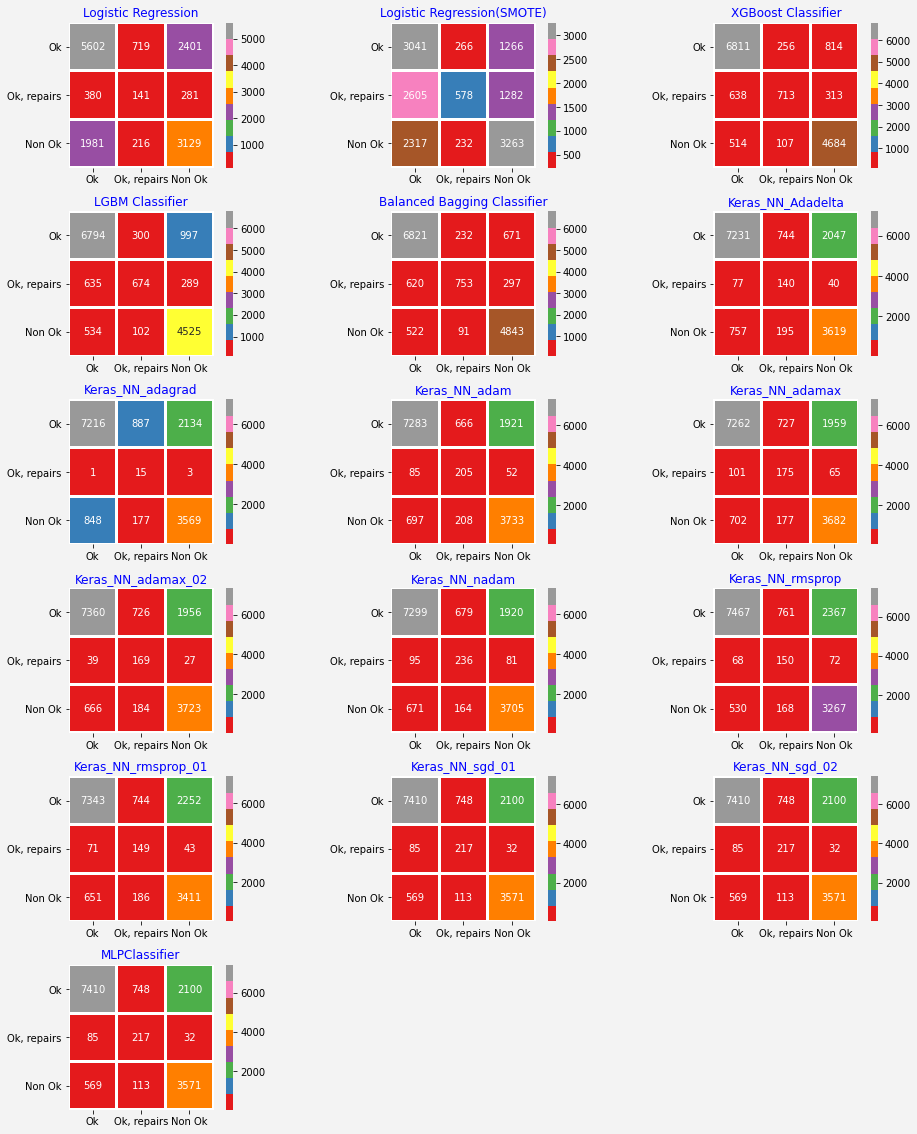

In [0]:
l_modelos = ['adadelta','adagrad','adam','adamax','nadam','rmsprop',
             'sgd_01','sgd_02']

lst    = [logit,logit_smote,xgc,lgbm_c,bbc,
          modelo_adadelta, modelo_adagrad, modelo_adam, modelo_adamax,
          modelo_adamax_02,modelo_nadam, modelo_rmsprop,model,
          modelo_sgd_01, modelo_sgd_02,clf]

length = len(lst)

mods   = ['Logistic Regression','Logistic Regression(SMOTE)',
          'XGBoost Classifier','LGBM Classifier','Balanced Bagging Classifier',
          'Keras_NN_Adadelta','Keras_NN_adagrad','Keras_NN_adam',
          'Keras_NN_adamax','Keras_NN_adamax_02','Keras_NN_nadam','Keras_NN_rmsprop',
          'Keras_NN_rmsprop_01','Keras_NN_sgd_01', 'Keras_NN_sgd_02','MLPClassifier']

fig = plt.figure(figsize=(16,20))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(6,3,j+1)
    if   (j+1) <  6:
      predictions = i.predict(test_X)
      conf_matrix = confusion_matrix(predictions,test_Y)
    elif (j+1) < 14:
      predictions = i.predict_classes(X_test_,batch_size=32, verbose = 0)
      conf_matrix = confusion_matrix(predictions,np.argmax(y_test_, axis=1))
    else           :
      predictions = clf.predict(X_test_)
      conf_matrix = confusion_matrix(predictions.dot(clf.classes_),np.argmax(y_test_, axis=1))[:3,:3]
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["Ok","Ok, repairs","Non Ok"],
                yticklabels=["Ok","Ok, repairs","Non Ok"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

# <a id='4'>4. Conclusión</a>

Tal como se comentó en un inicio, a los modelos predictivos del estado de funcionamiento de las Bombas de agua en Tanzania ya implementados, se agregaron modelos basados en Redes Neuronales.
De tal manera que con relación a los modelos implementados se tiene que:

1.   Originalmente se implementaron 5 modelos predictivos.
2.   Se agregaron 10 modelos predictivos de Redes Neuronales, usando Keras. En donde se realizaron variaciones de los optimizadores usados(tomando hiperparámetos desde la documentacion de Keras), o variaciones en la cantidad de neuronas por capas, u otas variaciones.
3.   Se agregó 1 modelo predictivo usando MLPClassifier de sklearn.

Para todos los modelos de Redes Neuronales sus accuracy variaron entre 0.69 y 0.75. En tanto que para los otros modelos predictivos sus accuracy variaron entre 0.45 y 0.83.

En general el tiempo de procesamiento para el entrenamiento de las Redes Neuronales fue significativamente mayor que el tiempo tomado por los otros modelos predictivos. Junto con ello la necesidad de recursos, tales como memoria o capacidad de procesamiento, requerido por los modelos predictivos basado en Redes Neuronales, son mayores que los recursos requeridos por los otros modelos predictivos. Esto fue el motivo por el cual, este desafío lo tuvimos que abordad usando Google-Colab y no los computadores personales, que disponen de recursos de memoria y procesamiento más limitados.

Una parte importante del tiempo de modelamiento, lo consume el tunnig de la red neuronal. Ir cambiando cada uno de los distintos hiperparámetros, o incluso variar el optimizador, para luego realizar el entrenamiento y la evaluación, consume tiempo, al ir iterando y comparando los resultados de las métricas obtenidas. En particular, en nuestro caso usamos la métrica accuracy.

Una de las ventajas que observamos de los modelos de Redes Neuronales que implementamos, es que a nivel de accuracy su menor valor es cercano al 0.70, en tanto que para los otros modelos el valor menor del accuracy es 0.40.

Por complemento, una desventaja de los modelos de Redes Neuronales, fue que su mayor valor de accuracy fue cercano al 0.75, en tanto que para los otros modelos el valor mayor de accuracy fue 0.83.

Lo anterior mencionado, pro y contra de los modelos de Redes Neuronales versus los otros modelos predictivos implementados, nos lleva a creer que las Redes Neuronales podrian ser más flexibles en terminos de aplicarse a distintos problemas predictivos que se requieren abordar. Pero lograr un mejor resultado de las métricas, requiere una mayor inversión de tiempo.


De los 16 modelos predictivos experimentados para resolver esta problemática de conocer el estado funcional de las Bombas de agua, se tiene que los 3 primeros con mejores resultados no son Redes Neuronales(ver 3. Rendimiento de modelos)

Creemos que invirtiendo un poco más de tiempo, para experimentar con las topologías de las Redes Neuronales y junto con ello, ir variando los valores de los distintos hiperparámetros usados, podemos lograr un mejor resultado de la métrica accuracy. 

Por último comentar que este deafío junto con permitirnos conocer, implementar y experimentar con Redes Neuronales, nos ha permitido también hacer comparativas con otros modelos predictivos, teniendo asi una visión más amplia.